# Build neural networks with TensorFlow for collaborative filtering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Concatenate, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

### Data preparation

In [2]:
df = pd.read_csv("small_rating.csv")

In [3]:
userIds = sorted(df["userId"].unique())
movieIds = sorted(df["movieId"].unique())

In [4]:
print("number of users: {}".format(len(userIds)))
print("number of movies: {}".format(len(movieIds)))

number of users: 500
number of movies: 200


In [5]:
print(userIds[:10])
print(movieIds[:10])

[156, 741, 768, 775, 903, 982, 1849, 2261, 2397, 3284]
[1, 2, 6, 10, 11, 16, 17, 19, 21, 25]


We need to map the users and movies to new IDs that are continuous integers starting from 0. This is to save the space.

In [6]:
df2 = df[["userId", "movieId", "rating"]].copy()
df2["userId"] = df2["userId"].map({v:k for k, v in enumerate(userIds)})
df2["movieId"] = df2["movieId"].map({v:k for k, v in enumerate(movieIds)})

In [7]:
N = df2.userId.max() + 1
M = df2.movieId.max() + 1

In [8]:
N, M

(500, 200)

In [9]:
df2 = shuffle(df2)

In [10]:
df2.head()

,userId,movieId,rating
38370,221,90,5.0
68088,393,199,4.5
49543,286,23,1.0
24450,141,4,3.0
5945,34,53,2.0


Split data into train dataset and test dataset.

In [14]:
cutoff = int(0.8 * len(df2))
df_train = df2.iloc[:cutoff]
df_test = df2.iloc[cutoff:]

In [15]:
df_train.shape, df_test.shape

((69212, 3), (17304, 3))

In [100]:
K = 10
mu = df_train.rating.mean()
epoch = 50
reg = 0
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m)
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m)
# x = Dot(axes=2)([u_embedding, m_embedding])
# x = Add()([x, u_bias, m_bias])
# x= Flatten()(x)
x = Concatenate(axis=-1)([u_embedding, m_embedding])
x = Flatten()(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.5)(x)
# x = Dense(16)(x)
x = Dense(1)(x)
model = Model(inputs = [u, m], outputs = x)
model.compile(
    loss='mse',
    optimizer=SGD(learning_rate=0.08, momentum=0.9),
    metrics=['mse']
)
r = model.fit(
    x = [df_train.userId.values, df_train.movieId.values],
    y = df_train.rating.values - mu,
    epochs = epoch,
    batch_size=128,
    validation_data=(
        [df_test.userId.values, df_test.movieId.values],
        df_test.rating.values - mu
    )
)

Epoch 1/50
541/541 [==============================] - 2s 3ms/step - loss: 0.7512 - mse: 0.7512 - val_loss: 0.6820 - val_mse: 0.6820
Epoch 2/50
541/541 [==============================] - 1s 2ms/step - loss: 0.6713 - mse: 0.6713 - val_loss: 0.6643 - val_mse: 0.6643
Epoch 3/50
541/541 [==============================] - 1s 2ms/step - loss: 0.6480 - mse: 0.6480 - val_loss: 0.6484 - val_mse: 0.6484
Epoch 4/50
541/541 [==============================] - 1s 2ms/step - loss: 0.6366 - mse: 0.6366 - val_loss: 0.6332 - val_mse: 0.6332
Epoch 5/50
541/541 [==============================] - 1s 2ms/step - loss: 0.6284 - mse: 0.6284 - val_loss: 0.6623 - val_mse: 0.6623
Epoch 6/50
541/541 [==============================] - 1s 2ms/step - loss: 0.6236 - mse: 0.6236 - val_loss: 0.6321 - val_mse: 0.6321
Epoch 7/50
541/541 [==============================] - 1s 2ms/step - loss: 0.6197 - mse: 0.6197 - val_loss: 0.6261 - val_mse: 0.6261
Epoch 8/50
541/541 [==============================] - 1s 2ms/step - loss: 0.

In [101]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_56 (Embedding)       (None, 1, 10)        5000        ['input_29[0][0]']               
                                                                                                  
 embedding_57 (Embedding)       (None, 1, 10)        2000        ['input_30[0][0]']               
                                                                                           

In [102]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_56 (Embedding)       (None, 1, 10)        5000        ['input_29[0][0]']               
                                                                                                  
 embedding_57 (Embedding)       (None, 1, 10)        2000        ['input_30[0][0]']               
                                                                                           

In [103]:
r.history

{'loss': [0.7512064576148987,
  0.6713409423828125,
  0.6479830741882324,
  0.6366281509399414,
  0.6284306645393372,
  0.6235662698745728,
  0.6197254061698914,
  0.6140696406364441,
  0.6139525175094604,
  0.608763575553894,
  0.6087964773178101,
  0.6090925931930542,
  0.6078205704689026,
  0.6049016118049622,
  0.6018759608268738,
  0.601567268371582,
  0.6011996269226074,
  0.594953715801239,
  0.5933656096458435,
  0.5937353372573853,
  0.5895199775695801,
  0.5873669385910034,
  0.5854536890983582,
  0.58172607421875,
  0.5791833400726318,
  0.5764384865760803,
  0.5710066556930542,
  0.5700132846832275,
  0.5660186409950256,
  0.5635261535644531,
  0.5625637173652649,
  0.5578954219818115,
  0.5563939213752747,
  0.5557050704956055,
  0.5548427700996399,
  0.5529617071151733,
  0.5497671961784363,
  0.5505266785621643,
  0.5455414056777954,
  0.5424551963806152,
  0.5416626930236816,
  0.540561318397522,
  0.539304256439209,
  0.5356658697128296,
  0.5359862446784973,
  0.53137

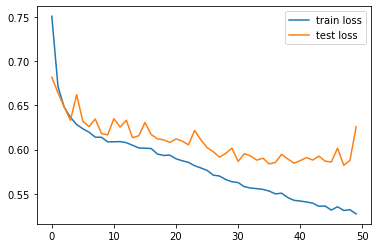

In [104]:
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

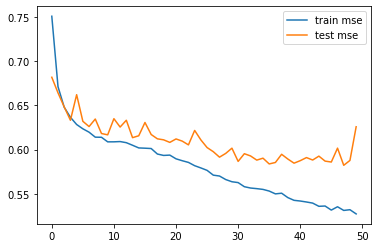

In [105]:
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [107]:
from scipy.sparse import csr_matrix

In [122]:
df2_shuffled = shuffle(df2)
cutoff = int(0.8 * len(df2))
train = df2_shuffled.iloc[:cutoff]
test = df2_shuffled.iloc[cutoff:]

In [123]:
N = df2.userId.max() + 1
M = df2.movieId.max() + 1
A = csr_matrix((train.rating, (train.userId, train.movieId)), shape=(N, M))
A_test = csr_matrix((test.rating, (test.userId, test.movieId)), shape=(N, M))

In [150]:
N, M

(500, 200)

In [127]:
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

In [130]:
mu = A.sum() / mask.sum()

In [131]:
mu

3.654337398139051

In [133]:
import keras.backend as K

In [218]:
def custome_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    return sse / n

batch_size=128
reg = 0.00001

def generator(A, M):
    while True:
        A, M = shuffle(A, M)
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            a = a - mu * m
            noisy = a
            yield noisy, a

def test_generator(A, M, A_test, M_test):
    while True:
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1) * batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            at = A_test[i*batch_size:upper].toarray()
            mt = M_test[i*batch_size:upper].toarray()
            a = a - mu * m
            at = at - mu * mt
            yield a, at


In [219]:
i = Input(shape=(M,))
x = Dropout(0.7)(i)
x = Dense(100, activation='tanh', kernel_regularizer=l2(reg))(x)
outputs = Dense(M, kernel_regularizer=l2(reg))(x)

model = Model(inputs = i, outputs = outputs)

In [220]:
model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 200)]             0         
                                                                 
 dropout_24 (Dropout)        (None, 200)               0         
                                                                 
 dense_68 (Dense)            (None, 100)               20100     
                                                                 
 dense_69 (Dense)            (None, 200)               20200     
                                                                 
Total params: 40,300
Trainable params: 40,300
Non-trainable params: 0
_________________________________________________________________


In [221]:
model.compile(
    loss = custome_loss,
    optimizer=SGD(learning_rate=0.07, momentum=0.9),
    metrics=[custome_loss] 
)

r = model.fit(
    generator(A, mask),
    validation_data=test_generator(A, mask, A_test, mask_test),
    epochs=100,
    steps_per_epoch=A.shape[0] // batch_size + 1,
    validation_steps=A_test.shape[0] // batch_size + 1
)

Epoch 1/100
4/4 [==============================] - 1s 56ms/step - loss: 1.3543 - custome_loss: 1.3506 - val_loss: 1.1629 - val_custome_loss: 1.1593
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.3134 - custome_loss: 1.3098 - val_loss: 1.0974 - val_custome_loss: 1.0937
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 1.2538 - custome_loss: 1.2496 - val_loss: 1.0244 - val_custome_loss: 1.0207
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 1.1897 - custome_loss: 1.1862 - val_loss: 0.9552 - val_custome_loss: 0.9515
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1147 - custome_loss: 1.1109 - val_loss: 0.8941 - val_custome_loss: 0.8904
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0452 - custome_loss: 1.0433 - val_loss: 0.8425 - val_custome_loss: 0.8388
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9846 - custome_loss: 0.9826 - val_loss

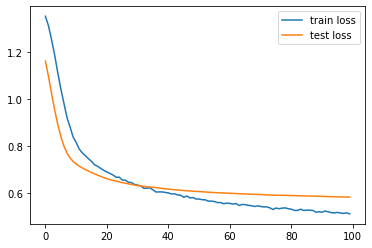

In [222]:
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

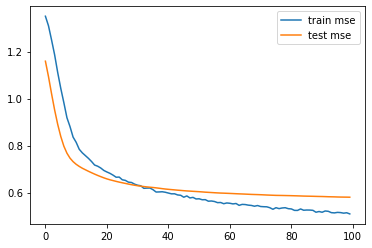

In [223]:
plt.plot(r.history['custome_loss'], label="train mse")
plt.plot(r.history['val_custome_loss'], label="test mse")
plt.legend()
plt.show()